In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons, make_circles, make_classification
import random

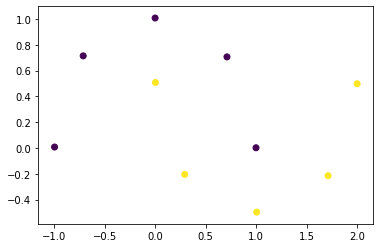

In [14]:
X, y = make_moons(n_samples = 10, noise = 0.005, random_state = 417) 

plt.scatter(X[:, 0], X[:, 1], c = y) 
plt.show()

In [213]:
class linear_kernel:
    def run(self, x, y):
        return(np.dot(x.T, y))

class poly_kernel:
    def __init__(self, c0=1, d=3, gamma = None):
        self.c0 = c0
        self.d = d
        self.gamma = gamma
        
    def run(self, x, y):
        if (self.gamma == None):
            self.gamma = 1 / x.size
            
        return((self.gamma * np.dot(x.T, y) + self.c0) ** self.d)
    
class sigmoid_kernel:
    def __init__(self, c0=1, gamma=None):
        self.c0 = c0
        self.gamma = gamma
        
    def run(self, x, y):
        if (self.gamma == None):
            self.gamma = 1 / x.size
            
        return(np.tanh(self.gamma * np.dot(x.T, y) + self.c0))
        
class rbf_kernel:
    def __init__(self, sigma):
        self.sigma = sigma
        
    def run(self, x, y):
        if np.ndim(x) == 1 and np.ndim(y) == 1:
            result = np.exp(- (np.linalg.norm(x - y, 2)) ** 2 / (2 * self.sigma ** 2))
        elif (np.ndim(x) > 1 and np.ndim(y) == 1) or (np.ndim(x) == 1 and np.ndim(y) > 1):
            result = np.exp(- (np.linalg.norm(x - y, 2, axis=1) ** 2) / (2 * self.sigma ** 2))
        elif np.ndim(x) > 1 and np.ndim(y) > 1:
            result = np.exp(- (np.linalg.norm(x[:, np.newaxis] - y[np.newaxis, :], 2, axis=2) ** 2) / (2 * self.sigma ** 2))
        return result
    
def get_gram_matrix(kernel, X):
    K = kernel.run(X, X)
    return K

In [239]:
class SupportVectorDataDescription:
    def __init__(self, krn="rbf", max_iterations=30000, opt_precision=0.00001, C=0.5, c0=1, d=3, gamma=0.1, sigma=2.23):
        self.max_iterations = max_iterations
        self.krn = krn
        self.opt_precision = opt_precision
        self.c0 = c0
        self.d = d
        self.gamma = gamma
        self.sigma = sigma
        self.C = C
        
        
    def fit(self, X):
        self.X = X
        
        if (self.krn == "rbf"):
            self.kernel = rbf_kernel(self.sigma)
        if (self.krn == "linear"):
            self.kernel = linear_kernel()
        if (self.krn == "poly"):
            self.kernel = poly_kernel(self.c0, self.d, self.gamma)
        if (self.krn == "sigmoid"):
            self.kernel = sigmoid_kernel(self.c0, self.gamma)
        
        K = get_gram_matrix(self.kernel, X)
        self.K = K
        
        self.alfas = self.initialize_alpha(X)
        dist_to_center, dist_to_decision_boundary, R = self.smo(K)
        
        
        
    
    def smo(self, K):
        iteration = 0
        
        dist_to_center, dist_to_decision_boundary, R = self.calculate_predictions(K)
        
        while iteration < self.max_iterations:
            black_list = set()
            iteration += 1
            
            KKT_violation_idxs = []
            for i in range(self.alfas.shape[0]):
                if self.violates_KKT_condition(i, dist_to_decision_boundary) and not(i in black_list):
                    KKT_violation_idxs.append(i)
                    
            
            if len(KKT_violation_idxs) == 0:
                print("Finished optimization. No more violations.")
                self.R = R
                return dist_to_center, dist_to_decision_boundary, R
            else:
                dist_to_center, dist_to_decision_boundary, R = self.examine_and_update_predictions(R, dist_to_center,
                                                                                             dist_to_decision_boundary,
                                                                                             KKT_violation_idxs,
                                                                                             black_list,
                                                                                             K)
    
            sv_larger_than_zero = self.alfas > self.opt_precision
            sv_smaller_than_C = self.alfas < (self.C - self.opt_precision)
        
            sv_larger_than_zero_idx = np.where(sv_larger_than_zero)
            sv_smaller_than_C_idx = np.where(sv_smaller_than_C)
        
            SV_nb = np.intersect1d(sv_larger_than_zero_idx, sv_smaller_than_C_idx)
            KKT_violations_in_SV_nb = []
            for i in SV_nb:
                if self.violates_KKT_condition(i, dist_to_decision_boundary) and not(i in black_list):
                    KKT_violations_in_SV_nb.append(i)
            
        
            while len(KKT_violations_in_SV_nb) > 0 and iteration < self.max_iterations:
                iteration += 1
                dist_to_center, dist_to_decision_boundary, R = self.examine_and_update_predictions(R, dist_to_center,
                                              dist_to_decision_boundary,
                                              KKT_violations_in_SV_nb,
                                              black_list,
                                              K)
                KKT_violations_in_SV_nb = []
                for i in SV_nb:
                    if self.violates_KKT_condition(i, dist_to_decision_boundary) and not(i in black_list):
                        KKT_violations_in_SV_nb.append(i)
                        
        print("Reached maximum iterations")
        self.R = R
        return dist_to_center, dist_to_decision_boundary, R
    
    
    def predict(self, X_new):
        ct_term = 0
        for i in range(self.alfas.shape[0]):
            for j in range(self.alfas.shape[0]):
                ct_term += self.alfas[i] * self.alfas[j] * self.K[i][j]
        
        
        first_term = self.kernel.run(X_new, X_new)
        first_term = first_term.diagonal()
        
        
        second_term =  np.multiply(self.kernel.run(X_new, self.X), self.alfas)
        second_term = 2 * np.sum(second_term, axis=1)
        
        distances_to_center = first_term - second_term + ct_term
        distance_to_decision_boundary = distances_to_center - self.R
        
        return distance_to_decision_boundary
    
    def comp_c(self, i, i1, i2, K):
        c_i = 0
        for j in range(self.alfas.shape[0]):
            if j == i1 or j == i2:
                continue
            
            c_i += self.alfas[j] * K[i][j]
            
        
        return c_i
    
    def take_step(self, i1, i2, K):
        if i1 == i2:
            return False
        
        L = max(0, self.alfas[i1] + self.alfas[i2] - self.C)
        H = min(self.C, self.alfas[i1] + self.alfas[i2])
        
        if abs(L - H) < self.opt_precision:
            return False
        
        
        delta = self.alfas[i1] + self.alfas[i2]
        
        c_i1 = self.comp_c(i1, i1, i2, K)
        c_i2 = self.comp_c(i2, i1, i2, K)
        
        alpha2 = (2 * delta * (K[i1, i1] - K[i1,i2]) + c_i1 - c_i2 - K[i1, i1] + K[i2, i2]) / (2 * K[i1,i1] - 4 * K[i1,i2] + 2 * K[i2,i2])
        
        if alpha2 > H:
            alpha2 = H
        elif alpha2 < L:
            alpha2 = L
            
        
        if abs(self.alfas[i2] - alpha2) < self.opt_precision * (alpha2 + self.alfas[i2] + self.opt_precision):
            return False
        else:
            alpha1 = delta - alpha2
            self.alfas[i1] = alpha1
            self.alfas[i2] = alpha2
            return True
            
        
    def examine_example(self, i2, K):
        sv_larger_than_zero = self.alfas > self.opt_precision
        sv_smaller_than_C = self.alfas < (self.C - self.opt_precision)
        
        sv_larger_than_zero_idx = np.where(sv_larger_than_zero)
        sv_smaller_than_C_idx = np.where(sv_smaller_than_C)
        
        candidates = np.intersect1d(sv_larger_than_zero_idx, sv_smaller_than_C_idx)
        
        if len(candidates) != 0:
            np.random.shuffle(candidates)
            for i1 in candidates:
                if self.take_step(i1, i2, K):
                    return True
        
        rng = np.array(range(self.alfas.shape[0]))
        np.random.shuffle(rng)
        for i1 in rng:
            if self.take_step(i1, i2, K):
                return True
        
        return False
            
    
    
    def examine_and_update_predictions(self, R, dist_to_center, dist_to_decision_boundary, KKT_violation_idxs, black_list, K):
        i2 = random.choice(KKT_violation_idxs)
        
        if (self.examine_example(i2, K)):
            dist_to_center, dist_to_decision_boundary, R = self.calculate_predictions(K)
        else:
            black_list.add(i2)
            
        return dist_to_center, dist_to_decision_boundary, R
    

    def initialize_alpha(self, X):
        n_init = int(1/self.C) + 1
        self.alfas = np.zeros(X.shape[0])
        
        self.alfas[random.sample(range(X.shape[0]), n_init)] = 1/n_init
        return self.alfas
    
    def calculate_predictions(self, K):
        sv_larger_than_zero = self.alfas > self.opt_precision
        sv_smaller_than_C = self.alfas < (self.C - self.opt_precision)
        
        sv_larger_than_zero_idx = np.where(sv_larger_than_zero)
        sv_smaller_than_C_idx = np.where(sv_smaller_than_C)
        
        
        ct_term = 0
        for i in np.nditer(sv_larger_than_zero_idx):
            for j in np.nditer(sv_larger_than_zero_idx):
                ct_term += self.alfas[i] * self.alfas[j] * K[i][j]
        
        distances_to_center = []
        
        for z in range(self.alfas.shape[0]):
            s = 0
            for i in np.nditer(sv_larger_than_zero_idx):
                s += self.alfas[i] * K[i][z]
            
            distances_to_center.append(K[z][z] - 2 * s + ct_term)
       
        sv_between_zero_and_C = np.intersect1d(sv_larger_than_zero_idx, sv_smaller_than_C_idx)
    
        if (len(sv_between_zero_and_C) != 0):
            R = np.mean(np.array(distances_to_center)[sv_between_zero_and_C])
        else:
            R = ((np.min(np.array(distances_to_center)[sv_larger_than_zero_idx])) + (np.max(np.array(distances_to_center)[sv_larger_than_zero_idx]))) / 2
            
            
        distance_to_decision_boundary = distances_to_center - R
        
        return distances_to_center, distance_to_decision_boundary, R
    
    
    def violates_KKT_condition(self, i2, dist_to_decision_boundary):
        cond1 = (self.alfas[i2] > self.opt_precision and dist_to_decision_boundary[i2] < -self.opt_precision)
        # inside the decision boundary, but alfa != 0
        
        cond2 = (self.alfas[i2] < self.C - self.opt_precision and dist_to_decision_boundary[i2] > self.opt_precision)
        # outside the decision boundary, but alfa != C
    
        return (cond1 or cond2)
    
        


In [324]:
svdd = SupportVectorDataDescription(max_iterations=100000, opt_precision=0.01, C=10)
svdd.fit(X_train)

Finished optimization. No more violations.


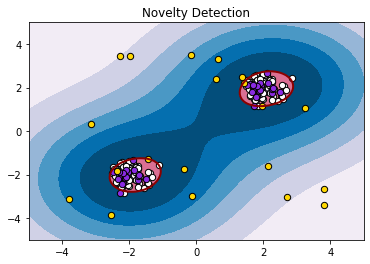

In [325]:
Z = svdd.predict(np.c_[xx.ravel(), yy.ravel()])
Z = -Z.reshape(xx.shape)

plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 40
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s, edgecolors='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s,
                 edgecolors='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s,
                edgecolors='k')

plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.show()

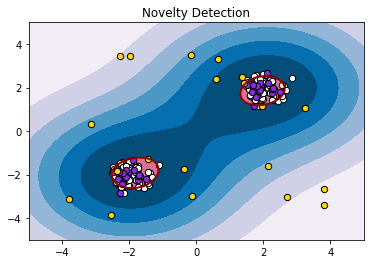

In [323]:
from sklearn import svm

xx, yy = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
# Generate train data
X = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * np.random.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X_train)

# plot the line, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 40
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s, edgecolors='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s,
                 edgecolors='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s,
                edgecolors='k')

plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.show()